In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import os
import json
import time
from PIL import Image
import seaborn as sns


In [2]:
# Define the network
class model_for_mnist(nn.Module):
    def __init__(self, num_classes=10, init_weights=False):
        super(model_for_mnist, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 24, kernel_size=5, padding=(2, 2)),      # input[1, 28, 28]  output[24, 28, 28]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),          # output[24, 14, 14]
            nn.Conv2d(24, 48, kernel_size=5, padding=(1, 1)),      # output[48, 12, 12]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),          # output[48, 6, 6]
            nn.Conv2d(48, 64, kernel_size=5, padding=(1, 1)),      # output[64, 4, 4]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),          # output[64, 2, 2]
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),                    #adding dropout for experiment and a an extra hidden fully connected layer 
            nn.Linear(64*2*2, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256,num_classes),
            
        )
        if init_weights:
            self._initialize_weights()
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)          #flatten input tensor  torch.tensor.view() can be used alternatively
        x = self.classifier(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)  #assigning values from normal distribution
                nn.init.constant_(m.bias, 0)

In [3]:
#device : GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Create data loader class

class DataLoader :
    def __init__(self):
        super().__init__()
        
    def load_MNIST(self,image_path,trans):
        #download training and testing dataset which are already divided in mnist,60000 sample for train_set, 10000 samples for test_set
        train_set = datasets.MNIST(root=image_path, transform = trans, train = True, download = True)
        test_dataset = datasets.MNIST(root=image_path, transform = trans, train = False, download = True)
        return train_set, test_dataset
    
    def load_data(self,val_split, batch_size):
        #Data transformation
        trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
        image_path = os.path.abspath(os.getcwd()) # mnist dataset path 
        train_set, test_dataset =self.load_MNIST(image_path, trans)
        
        # Create indices for the split later
        dataset_size = len(train_set)
        val_size = int(val_split * dataset_size)
        train_size = dataset_size - val_size
    
        # Split train_set into train_dataset and val_dataset for training and validation, respectively
        train_dataset, val_dataset = torch.utils.data.random_split(train_set,
                                                   [train_size, val_size])
        
        #load the train_dataset and val_dataset into train_loader and val_loader
        train_loader = torch.utils.data.DataLoader(
                        train_dataset,
                        batch_size=batch_size,
                        shuffle=True)
        val_loader = torch.utils.data.DataLoader(
                        val_dataset,
                        batch_size=batch_size,
                        shuffle=True)

        return train_loader, val_loader, train_dataset, val_dataset, test_dataset


In [5]:
#load the data
loader = DataLoader()

# Here train_dataset will have 55000 samples and val_dataset will have 5000 samples
train_loader, val_loader, train_dataset, val_dataset, test_dataset = loader.load_data(1/12,100)

In [6]:
# training and validation

net = model_for_mnist(num_classes=10, init_weights=True)     # instantiate the network（number of classes set to 10，weights initialization）
net.to(device)                                               # assign the network to the specified device to be trained (GPU/CPU)
loss_function = nn.CrossEntropyLoss()                        # cross-entropy loss
optimizer = optim.Adam(net.parameters(), lr=0.0002)          # uses Adam optimizer(network parameters，learning rate), which is SGD based as required in the assignment

save_path = './model_for_mnist.pth'
best_acc = 0.0
losses = []
accuracies = []

for epoch in range(10):
    ########################################## training ###############################################
    net.train()                         # enable Dropout
    running_loss = 0.0                  # initialize running-loss to 0 at the beginning of every epoch
    time_start = time.perf_counter()    # time each epoch
    
    for step, data in enumerate(train_loader, start=0):  # traverse the training set，start counting steps from 0
        images, labels = data   # acquire the data and labels of images in each batch
        optimizer.zero_grad()   # set prior calculated gradient to 0
        
        outputs = net(images.to(device))                 # forward propagation
        loss = loss_function(outputs, labels.to(device)) # computing the average loss for each image in the batch
        loss.backward()                                  # back propagation
        optimizer.step()                                 # update params of the optimizer
        running_loss += loss.item()*len(images) #loss.item() is multiplied by batch size given by len(images) because what loss.item returns is a an average loss across the batch
        
        # visualizing training progress 
        rate = (step + 1) / len(train_loader)           # current progress = current step / total steps in one epoch
        a = "*" * int(rate * 50)
        b = "." * int((1 - rate) * 50)
        print("\rEpoch training progress: {:^3.0f}%[{}->{}] Average loss of the last batch: {:.3f}".format(int(rate * 100), a, b, loss.item()), end="")
    print()
    print('Time taken: %f s' % (time.perf_counter()-time_start))

    ########################################### validation ###########################################
    net.eval()    # disable Dropout
    acc = 0.0  
    with torch.no_grad():
        for val_data in val_loader:
            val_images, val_labels = val_data
            outputs = net(val_images.to(device))
            predict_y = torch.max(outputs, dim=1)[1]  # ouput the corresponding label of the biggest value in the 10 outputs from the linear classifeier as the final prediction
            acc += (predict_y == val_labels.to(device)).sum().item() #count the number of correct predictions in the batch and to the total count acc
        val_accurate = acc / len(val_dataset)   #computes overall accuracy
        
        # save the network weights of the one with the accuracy
        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)
            
        epoch_loss = running_loss / len(train_dataset) #which is the average loss across the whole dataset
        print('[epoch %d] epoch_loss: %.3f  test_accuracy: %.3f \n' %
              (epoch + 1, epoch_loss, val_accurate))
        losses.append(epoch_loss)
        accuracies.append(val_accurate*100)

print('Training Done')

D:\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch training progress: 100%[**************************************************->] Average loss of the last batch: 0.203
Time taken: 10.625596 s
[epoch 1] epoch_loss: 0.814  test_accuracy: 0.938 

Epoch training progress: 100%[**************************************************->] Average loss of the last batch: 0.139
Time taken: 9.419798 s
[epoch 2] epoch_loss: 0.235  test_accuracy: 0.962 

Epoch training progress: 100%[**************************************************->] Average loss of the last batch: 0.127
Time taken: 9.380320 s
[epoch 3] epoch_loss: 0.161  test_accuracy: 0.970 

Epoch training progress: 100%[**************************************************->] Average loss of the last batch: 0.137
Time taken: 9.392630 s
[epoch 4] epoch_loss: 0.126  test_accuracy: 0.976 

Epoch training progress: 100%[**************************************************->] Average loss of the last batch: 0.091
Time taken: 9.490037 s
[epoch 5] epoch_loss: 0.104  test_accuracy: 0.978 

Epoch training

In [7]:
def plot(x, y, ax, title, y_label,x_label,xlim,ylim):
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.plot(x, y, 'ok',ms=5)
    ax.plot(x, y,)
    ax.margins(x=0, y=0)

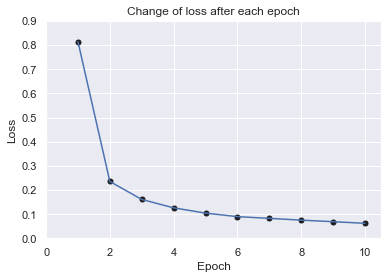

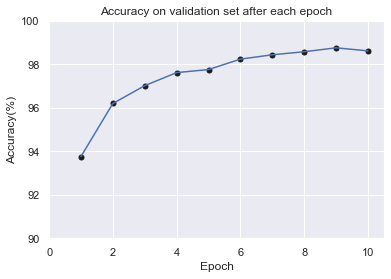

In [8]:
sns.set(style="darkgrid")
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
x=[1,2,3,4,5,6,7,8,9,10]
plot(x, losses, ax1, 'Change of loss after each epoch', 'Loss',"Epoch",[0,10.5],[0,0.9])
plot(x,accuracies,ax2, 'Accuracy on validation set after each epoch','Accuracy(%)',"Epoch",[0,10.5],[90,100])

As can be seen from the plots, the loss decreases gradually after each epoch while the model accurcy on the 10000-sample validation set keeps increasing from around 94% to about 99%.

In [9]:
# acquire the dictionary for target classes with elements in the form of "class: index" 
# i.e.{'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}
classes_list = test_dataset.class_to_idx
# swap the position of keys and vals in classes_list
cla_dict = dict((val, key) for key, val in classes_list.items())

# write cla_dict into a json file
json_str = json.dumps(cla_dict, indent=4)
with open('class_indices.json', 'w') as json_file:
    json_file.write(json_str)

Calssification results of the first 10 samples in the test dataset:


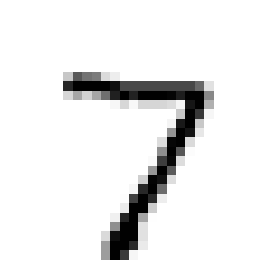

Predicted class is: 7 - seven 
Corresponding probability is: 0.999988317489624


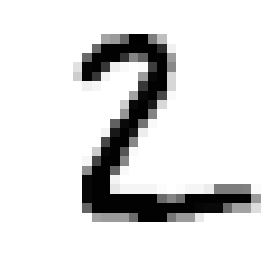

Predicted class is: 2 - two 
Corresponding probability is: 0.999840259552002


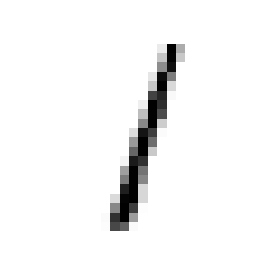

Predicted class is: 1 - one 
Corresponding probability is: 0.9998950958251953


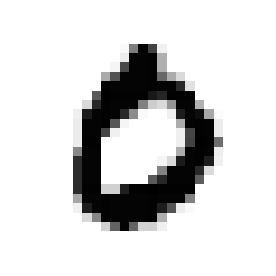

Predicted class is: 0 - zero 
Corresponding probability is: 0.9998693466186523


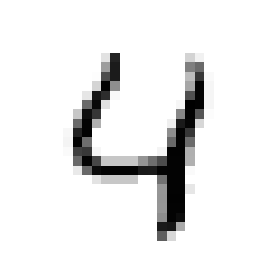

Predicted class is: 4 - four 
Corresponding probability is: 0.9999568462371826


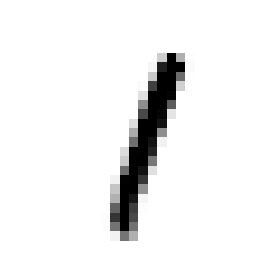

Predicted class is: 1 - one 
Corresponding probability is: 0.9999885559082031


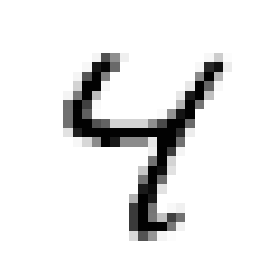

Predicted class is: 4 - four 
Corresponding probability is: 0.999355137348175


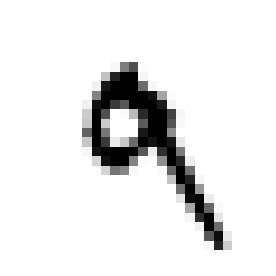

Predicted class is: 9 - nine 
Corresponding probability is: 0.9865210056304932


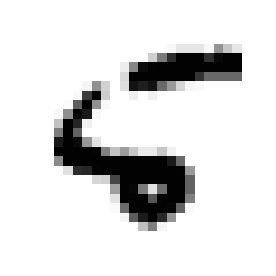

Predicted class is: 5 - five 
Corresponding probability is: 0.9897614121437073


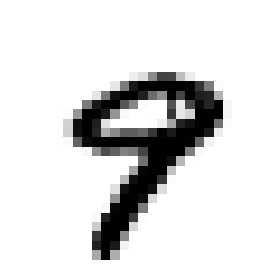

Predicted class is: 9 - nine 
Corresponding probability is: 0.9991353154182434

Overall accuracy on whole test set is 0.9894


In [10]:
# testing

# read class_indices.json into class_indict
try:
    json_file = open('./class_indices.json', 'r')
    class_indict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)

# create model
model = model_for_mnist(num_classes=10)
# load model weights
model_weight_path = "./model_for_mnist.pth"
model.load_state_dict(torch.load(model_weight_path))

# disable Dropout
model.eval()
correct = 0
i=0
print('\033[1m' + "Calssification results of the first 10 samples in the test dataset:")
with torch.no_grad():
    # predict class
    for test_image, image_label in test_dataset:
        test_image = torch.unsqueeze(test_image, dim=0)
        output = torch.squeeze(model(test_image))     # squeeze the output to get rid of the dimension for batch
        predict = torch.softmax(output, dim=0)
        predict_cla = torch.argmax(predict).numpy()
        if (predict_cla == image_label):
            correct+=1
        if(i<10):
            img = torch.squeeze(torch.squeeze(test_image))
            plt.imshow(img,cmap='Greys')
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            plt.show()
            print("Predicted class is:",class_indict[str(predict_cla)],"\nCorresponding probability is:",predict[predict_cla].item())
        i+=1
accuracy = correct / len(test_dataset)
print('\033[1m' + "\nOverall accuracy on whole test set is",accuracy)


# Summary
Network Structure Overview:
    
    1.Conv 2D, 24 filters, 5x5, stride 1x1, padding 2x2 ReLU + MaxPool2D (2x2)
    2.Conv 2D, 48 filters, 5x5, stride 1x1, padding 1x1 ReLU + MaxPool2D (2x2)
    3.Conv 2D, 64 filters, 5x5, stride 1x1, padding 1x1 ReLU + MaxPool2D (2x2)
    4.FC-1: The first fully connected layer has 256 neurons, with ReLU + Dropout
    5.FC-2: The second fully connected layer has 10 neurons corresponding one class each for output, with Dropout

Fundamental architectural modifications on the model include adding padding after each convolutional layer to prevent the size of input from becoming smaller than the size of filters. Other modifications include adding one extra hidden FC layer with 256 neurons with ReLU activation. Additionally, both the extra hidden FC layer and the output layer are equipped with dropout of 0.5 probability. However, aside from the necessary modification of padding, other modifications did not improve the performance of the model significantly as the suggested structure in the assignment instructions was already producing fine results with a final accuracy of close to 99% on the validation set.

The test result of the model on the test set of 10000 samples is consistent with the validation with an accuracy of about 99%, which shows good generalization ability of the model.

Plots of loss evolution and validation accuracies achieved by the model after each epoch are plotted in codes above.